<a href="https://colab.research.google.com/github/Gauransh777/Parameter-Optimization-assignment/blob/main/Parameter_Optimization_102203322.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import matplotlib.pyplot as plt
import os
import random
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
column_names = ['target', 'x_box', 'y_box', 'char_width', 'char_height', 'on_pixels', 'x_center', 'y_center',
                'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x_edge', 'xedge_var', 'y_edge', 'yedge_var']
df = pd.read_csv(dataset_url, header=None, names=column_names)

In [3]:
encoder = LabelEncoder()
df['target_encoded'] = encoder.fit_transform(df['target'])

In [4]:
features = df.drop(columns=['target', 'target_encoded'])
labels = df['target_encoded']

In [5]:
train_test_sets = []
for seed in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.3, random_state=seed)
    train_test_sets.append((X_train, X_test, y_train, y_test))

print(" Dataset prepared and 10 random splits created.")

 Dataset prepared and 10 random splits created.


In [6]:
tuning_results = []
accuracy_log = []

for idx, (train_X, test_X, train_y, test_y) in enumerate(train_test_sets):
    top_accuracy = 0
    config = {}
    acc_list = []

    for trial in range(100):
        chosen_kernel = random.choice(['linear', 'rbf', 'poly'])
        chosen_C = round(random.uniform(0.1, 10), 2)
        chosen_gamma = 'scale' if chosen_kernel == 'linear' else random.choice(['scale', 'auto'])
        chosen_degree = random.randint(2, 5) if chosen_kernel == 'poly' else None

        clf = SVC(kernel=chosen_kernel, C=chosen_C, gamma=chosen_gamma, degree=chosen_degree or 3)
        clf.fit(train_X, train_y)
        predictions = clf.predict(test_X)

        acc = accuracy_score(test_y, predictions)
        acc_list.append(acc)

        if acc > top_accuracy:
            top_accuracy = acc
            config = {
                "kernel": chosen_kernel,
                "C": chosen_C,
                "gamma": chosen_gamma,
                "degree": chosen_degree if chosen_kernel == 'poly' else "N/A"
            }

    tuning_results.append({
        "Split": f"Set {idx+1}",
        "Top Accuracy": round(top_accuracy * 100, 2),
        **config
    })
    accuracy_log.append(acc_list)

In [7]:
with open("svm_results_summary.json", "w") as file:
    json.dump(tuning_results, file, indent=4)

with open("svm_accuracies.json", "w") as file:
    json.dump(accuracy_log, file)

print("SVM tuning completed and results saved.")

SVM tuning completed and results saved.


In [8]:
with open("svm_results_summary.json", "r") as file:
    summary_data = json.load(file)

with open("svm_accuracies.json", "r") as file:
    accuracy_data = json.load(file)

print(" Results successfully loaded from saved files.")

 Results successfully loaded from saved files.


In [9]:
result_frame = pd.DataFrame(summary_data)
result_frame = result_frame.sort_values("Top Accuracy", ascending=False).reset_index(drop=True)
print("\n📊 Best Parameters for Each Sample (Table 1):\n")
print(result_frame)


📊 Best Parameters for Each Sample (Table 1):

    Split  Top Accuracy kernel     C gamma degree
0   Set 1         97.95    rbf  2.82  auto    N/A
1   Set 6         97.93    rbf  4.09  auto    N/A
2   Set 4         97.83    rbf  6.06  auto    N/A
3  Set 10         97.63    rbf  9.92  auto    N/A
4   Set 8         97.63    rbf  4.84  auto    N/A
5   Set 3         97.58    rbf  9.87  auto    N/A
6   Set 9         97.52    rbf  8.84  auto    N/A
7   Set 7         97.48    rbf  5.57  auto    N/A
8   Set 2         97.42    rbf  9.47  auto    N/A
9   Set 5         97.10    rbf  4.31  auto    N/A


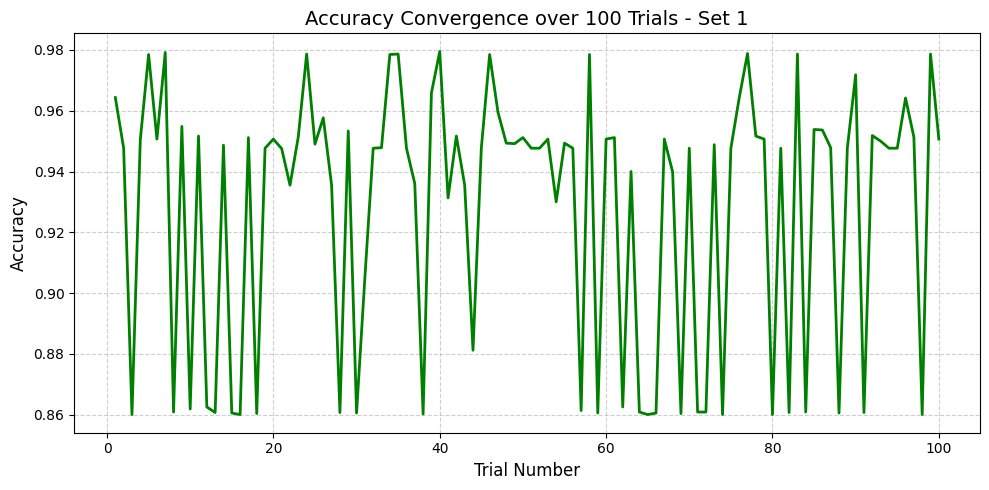

In [10]:
best_run_index = result_frame["Top Accuracy"].idxmax()
best_split_name = result_frame.loc[best_run_index, "Split"]
best_accuracy_series = accuracy_data[best_run_index]

# Ensure output folder exists
os.makedirs("graphs", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), best_accuracy_series, color='green', linewidth=2)
plt.title(f"Accuracy Convergence over 100 Trials - {best_split_name}", fontsize=14)
plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("graphs/convergence_plot.png")
plt.show()